In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from importlib import reload
from sklearn.metrics import f1_score

In [7]:
workers = 20
btch_sz = 8000
# ws = 0
ws = 50
sr = 0.5
ngpu = 1

In [8]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preprocessing

In [5]:
data = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [38]:
# data.iloc[:-100000].to_csv('data/train_new.csv', index=False)
data.iloc[2400000:2500000].to_csv('data/test_new.csv', index=False)

In [24]:
train_new.groupby(['open_channels_gessed']).count()

,time,signal,open_channels
open_channels_gessed,,,
-1,160000,160000,160000
1,28,28,28
2,239,239,239
3,1643,1643,1643
4,7105,7105,7105
5,21740,21740,21740
6,44649,44649,44649
7,63692,63692,63692
8,58856,58856,58856


In [10]:
n_unique = train_new.groupby(['open_channels_gessed']).count().open_channels.values[1:]
probs = n_unique/(len(train_new)-int(len(train_new)*0.4))
np.random.choice(10, 5, p=probs)

array([7, 6, 4, 6, 8])

NameError: name 'data_test' is not defined

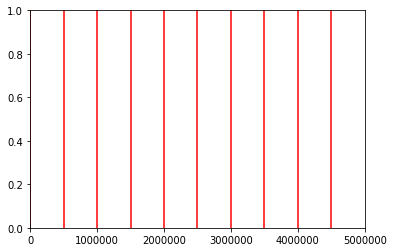

In [42]:
for i in range(10):
    plt.axvline(500000*i, color='red')
plt.xlim(0,5000000)
plt.plot(data_test.signal)
plt.show()

# AAAAAAAAAAAAAAAAAAAAAAAA

In [40]:
nb_train = 5
nb_test = 5

In [31]:
train = pd.read_csv('data/train_shifted_true.csv')

In [32]:
train = train.iloc[np.r_[0:3600000, 3850000:len(train)]]

In [33]:
train.to_csv('data/train_new.csv', index=False)

<IPython.core.display.Javascript object>


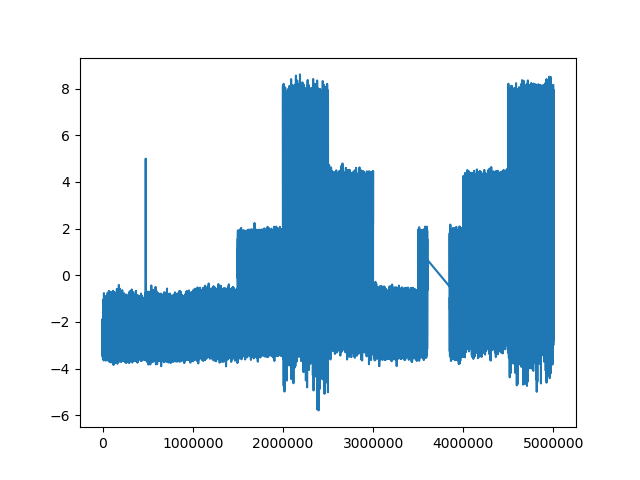

In [28]:
%matplotlib notebook
plt.plot(train.signal)
plt.show()

In [41]:
train = pd.read_csv('data/train_shifted_true.csv')
test = pd.read_csv('data/test_shifted_true.csv')

dev = train[(train.batch == 10)]
dev.to_csv('data/dev.csv', index=False)

# train = train[(train.batch == 5) | (train.batch == 10)]
train = train[train.batch == nb_train]
train.to_csv('data/train_new.csv', index=False)

test = test[test.batch == nb_test]
test.to_csv('data/test.csv', index=False)

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [161]:
train.groupby('open_channels').count()

,time,signal,batch
open_channels,,,
0,1923,1923,1923
1,23611,23611,23611
2,119295,119295,119295
3,295567,295567,295567
4,373428,373428,373428
5,186176,186176,186176


In [162]:
train

,time,signal,open_channels,batch
2500000,250.0001,2.855500,5,6.0
2500001,250.0002,3.090700,5,6.0
2500002,250.0003,3.527700,5,6.0
2500003,250.0004,3.982200,5,6.0
2500004,250.0005,3.336800,5,6.0
...,...,...,...,...
4499995,449.9996,1.908458,4,9.0
4499996,449.9997,2.065390,4,9.0
4499997,449.9998,1.742521,4,9.0
4499998,449.9999,1.588753,4,9.0


In [13]:
def getTrainRangesIx():    
    train_ranges={}
    s0=0
    for i in range(11):
        l=500000 #length
        if(i==1):l=100000
        if(i==2):l=400000
        train_ranges[i]=np.arange(s0,s0+l)
        s0+=l
    return train_ranges

# nBatches = 10
# nCh = [2,2,2,2,4,10,6,2,4,6,10]

In [ ]:
for b in range(nBatches):
        print("batch Nr: ", b, " nCh=",nCh[b])
        batch_ixs = getTrainRangesIx()[b]
        batch = data.loc[batch_ixs].groupby(['open_channels']).count().signal.values
        print(batch/len(batch_ixs)

In [ ]:
signal = np.array([train.signal.values[1:], train.signal.values[:-1]])
left_avr = np.mean(signal, axis=0)[:-3]
right_avr = np.mean(signal, axis=0)[3:]

train_new = pd.DataFrame({'left_avr': left_avr, 'right_avr': right_avr})
train_new['signal'] = train.signal.values[2:-2]
train_new['open_channels'] = train.open_channels.values[2:-2]

train_new.to_csv('data/train_new.csv', index=False)

train_new

In [ ]:
test_0 = pd.read_csv('data/git_data/test_5.csv')
# test_0.s2 = test_0.signal
test_0.to_csv('data/test.csv', index=False)
test_0

# Format Dataloaders

In [9]:
from dataUtils.CustomDataset import IonSwitchingDataset

ion_dataset_train = IonSwitchingDataset('data/train_new.csv', window_size=ws, slice_ratio=sr)
ion_dataset_test = IonSwitchingDataset('data/dev.csv', window_size=ws, slice_ratio=sr)
ion_dataset_submmit = IonSwitchingDataset('data/test_shifted_true.csv', window_size=ws, slice_ratio=sr, train=False)

In [10]:
dataloader = DataLoader(ion_dataset_train, batch_size=btch_sz, shuffle=True, num_workers=workers)
dataloader_test = DataLoader(ion_dataset_test, batch_size=25000, shuffle=False, num_workers=workers)
dataloader_submmit = DataLoader(ion_dataset_submmit, batch_size=5000, shuffle=False, num_workers=workers)

In [146]:
from dataUtils.CustomDataset import SequensDataset2

def getTestRangesIx():
    test_ranges={}
    for i in range(12):
        if i<10:
            l=100000 #length
            s= i*l   #start
            test_ranges[i]=np.arange(s,s+l)
        else:
            s+=l
            l=500000
            test_ranges[i]=np.arange(s,s+l)
    return test_ranges

def getTrainRangesIx():    
    train_ranges={}
    s0=0
    for i in range(11):
        l=500000 #length
        if(i==1):l=100000
        if(i==2):l=400000
        train_ranges[i]=np.arange(s0,s0+l)
        s0+=l
    return train_ranges

sequence_length = 25
hyp_probThr = 0.95
nCh_test =  {0:2, 1:4, 2:6, 3:4, 4:2, 5:11, 6:6, 7:11, 8:4, 9:4, 10:5, 11:4}
nCh_train = {0:2, 1:2, 2:2, 3:2, 4:4, 5:11, 6:6, 7:2,  8:4, 9:6, 10:11}
bNr_test = 5
bNr_train = 5

batch_ixs = getTrainRangesIx()[bNr_train]
# batch_ixs = getTestRangesIx()[bNr_train]

SequensDataset = SequensDataset2('data/train_thrCK.csv', seqL=sequence_length, probThr = hyp_probThr,
                                  num_classes=nCh_train[bNr_train], batch_ixs=batch_ixs,train=True)

In [147]:
dataloader = DataLoader(SequensDataset, batch_size=btch_sz, num_workers=workers, shuffle=True)

In [37]:
batch = next(iter(dataloader))

In [ ]:
batch['signal'].shape

In [39]:
batch['input'].shape, batch['open_channels'].shape

(torch.Size([8000, 1, 51]), torch.Size([8000, 11]))

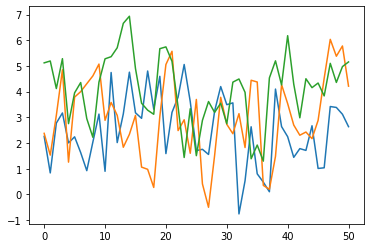

In [115]:
%matplotlib inline
plt.plot(batch['input'][0][0])
plt.plot(batch['input'][1][0])
plt.plot(batch['input'][2][0])
# plt.plot(np.where(batch['open_channels']==1)[1][:10])
# plt.plot(batch['input'][0][1])
# plt.plot(batch['input'][0][2])
plt.show()

# Load Model

In [11]:
import models.FCC as FCC
reload(FCC)

model = FCC.OpenChannelsClassifier_CNN2(1)
# model = FCC.OpenChannelsClassifier_FC(1)
# model = FCC.Seq_CNN(1)
model.apply(FCC.weights_init)
print(sum(p.numel() for p in model.parameters()))
model.to(device)
model = torch.nn.DataParallel(model)

824907


In [45]:
model(batch['input'].to(device).float().view(btch_sz, 1, ws+1)).shape

torch.Size([8000, 11])

# Optimirez and Criterion Loss

In [12]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [13]:
train_losses = np.array([])
train_accurasy = np.array([])
train_f1 = np.array([])
test_accurasy = np.array([])
test_f1 = np.array([])

In [14]:
batch_test = next(iter(dataloader_test))

# Training Loop

In [ ]:
num_epochs = 30
monit_res = 5
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        
        input, labels = batch['input'], batch['open_channels']
        input = input.to(device).float().view(len(input), 1, ws+1)
        labels = labels.to(device).float()     
    
        output = model(input).reshape(len(input), 11)
        
        loss = criterion(output, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        
        
        if i%monit_res == monit_res-1:
            model.eval()
            predicted_idx = torch.max(output, 1)[1]
            true_idx = torch.max(labels, 1)[1]
            predicted_idx = predicted_idx.cpu().detach()
            true_idx = true_idx.cpu().detach()
            accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)     
            f1 = f1_score(true_idx, predicted_idx, average='macro')
            train_accurasy = np.append(train_accurasy, accurasy)
            train_f1 = np.append(train_f1, f1)
            
            t_accurasy = 0
            t_f1 = 0
            
            input, labels = batch_test['input'], batch_test['open_channels']
            input = input.to(device).float().view(len(batch_test['input']), 1, ws+1)
            labels = labels.to(device).float()
            
            with torch.no_grad():
                output = model(input).reshape(len(input), 11)
            predicted_idx = torch.max(output, 1)[1]
            true_idx = torch.max(labels, 1)[1]
            predicted_idx = predicted_idx.cpu().detach()
            true_idx = true_idx.cpu().detach()
            t_accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)     
            t_f1 = f1_score(true_idx, predicted_idx, average='macro')
            test_accurasy = np.append(test_accurasy, t_accurasy)
            
            test_f1 = np.append(test_f1, t_f1)

            
            train_losses = np.append(train_losses, running_loss/monit_res)
            print('[{}/{}] [{}/{}], loss: {}, accyrasy: {}, f1: {}  f1_dev: {}'.format(epoch,
                                                     num_epochs,
                                                     i,
                                                     len(dataloader),
                                                     round(running_loss/monit_res, 4),
                                                     round(accurasy, 4),
                                                     round(f1, 4),
                                                     round(t_f1, 4)
                                                    )
                 )
            running_loss = 0.0
#             if t_f1 > 0.892:
#                 print(asd)
#             if t_f1 > 0.965:
#                 print(asd)

[0/30] [4/594], loss: 2.3072, accyrasy: 0.4414, f1: 0.1875  f1_dev: 0.0003
[0/30] [9/594], loss: 1.6806, accyrasy: 0.4424, f1: 0.1653  f1_dev: 0.0011
[0/30] [14/594], loss: 1.2378, accyrasy: 0.5444, f1: 0.2382  f1_dev: 0.0016
[0/30] [19/594], loss: 1.0035, accyrasy: 0.6115, f1: 0.3096  f1_dev: 0.0011
[0/30] [24/594], loss: 0.8741, accyrasy: 0.6569, f1: 0.4187  f1_dev: 0.0012
[0/30] [29/594], loss: 0.8046, accyrasy: 0.6773, f1: 0.4392  f1_dev: 0.0037
[0/30] [34/594], loss: 0.7621, accyrasy: 0.6789, f1: 0.4511  f1_dev: 0.017
[0/30] [39/594], loss: 0.7037, accyrasy: 0.7127, f1: 0.5113  f1_dev: 0.0899
[0/30] [44/594], loss: 0.6679, accyrasy: 0.7279, f1: 0.5306  f1_dev: 0.0688
[0/30] [49/594], loss: 0.6253, accyrasy: 0.7418, f1: 0.5521  f1_dev: 0.0403
[0/30] [54/594], loss: 0.5974, accyrasy: 0.7431, f1: 0.5701  f1_dev: 0.0346
[0/30] [59/594], loss: 0.5655, accyrasy: 0.7776, f1: 0.6314  f1_dev: 0.0198
[0/30] [64/594], loss: 0.5224, accyrasy: 0.7977, f1: 0.6332  f1_dev: 0.0295
[0/30] [69/594]

[0/30] [544/594], loss: 0.1524, accyrasy: 0.9297, f1: 0.8694  f1_dev: 0.5735
[0/30] [549/594], loss: 0.1283, accyrasy: 0.9581, f1: 0.9195  f1_dev: 0.5998
[0/30] [554/594], loss: 0.1376, accyrasy: 0.949, f1: 0.901  f1_dev: 0.6142
[0/30] [559/594], loss: 0.1313, accyrasy: 0.9535, f1: 0.9117  f1_dev: 0.5933
[0/30] [564/594], loss: 0.1264, accyrasy: 0.9537, f1: 0.9114  f1_dev: 0.5549
[0/30] [569/594], loss: 0.1228, accyrasy: 0.9566, f1: 0.9193  f1_dev: 0.5932
[0/30] [574/594], loss: 0.1194, accyrasy: 0.958, f1: 0.9216  f1_dev: 0.575
[0/30] [579/594], loss: 0.1221, accyrasy: 0.952, f1: 0.9167  f1_dev: 0.5792
[0/30] [584/594], loss: 0.1216, accyrasy: 0.9561, f1: 0.9179  f1_dev: 0.6147
[0/30] [589/594], loss: 0.1172, accyrasy: 0.9616, f1: 0.9275  f1_dev: 0.5784
[1/30] [4/594], loss: 0.1144, accyrasy: 0.9587, f1: 0.9233  f1_dev: 0.5892
[1/30] [9/594], loss: 0.119, accyrasy: 0.9574, f1: 0.9116  f1_dev: 0.5637
[1/30] [14/594], loss: 0.1182, accyrasy: 0.9599, f1: 0.9215  f1_dev: 0.616
[1/30] [19/

[1/30] [494/594], loss: 0.1197, accyrasy: 0.955, f1: 0.9156  f1_dev: 0.6034
[1/30] [499/594], loss: 0.1129, accyrasy: 0.9603, f1: 0.9291  f1_dev: 0.6072
[1/30] [504/594], loss: 0.1227, accyrasy: 0.9566, f1: 0.9275  f1_dev: 0.6215
[1/30] [509/594], loss: 0.1187, accyrasy: 0.955, f1: 0.9119  f1_dev: 0.6065
[1/30] [514/594], loss: 0.1211, accyrasy: 0.9516, f1: 0.9111  f1_dev: 0.6036
[1/30] [519/594], loss: 0.1265, accyrasy: 0.9534, f1: 0.9229  f1_dev: 0.6112
[1/30] [524/594], loss: 0.1202, accyrasy: 0.961, f1: 0.9224  f1_dev: 0.6074
[1/30] [529/594], loss: 0.1143, accyrasy: 0.9604, f1: 0.9258  f1_dev: 0.6069
[1/30] [534/594], loss: 0.113, accyrasy: 0.9589, f1: 0.9256  f1_dev: 0.6065
[1/30] [539/594], loss: 0.1118, accyrasy: 0.9615, f1: 0.9305  f1_dev: 0.6292
[1/30] [544/594], loss: 0.1139, accyrasy: 0.9571, f1: 0.9154  f1_dev: 0.6009
[1/30] [549/594], loss: 0.1071, accyrasy: 0.9653, f1: 0.9277  f1_dev: 0.5847
[1/30] [554/594], loss: 0.1095, accyrasy: 0.9581, f1: 0.9235  f1_dev: 0.6042
[1/

[2/30] [444/594], loss: 0.1124, accyrasy: 0.9591, f1: 0.9201  f1_dev: 0.6152
[2/30] [449/594], loss: 0.1106, accyrasy: 0.9597, f1: 0.9277  f1_dev: 0.5862
[2/30] [454/594], loss: 0.1166, accyrasy: 0.9613, f1: 0.922  f1_dev: 0.6295
[2/30] [459/594], loss: 0.1176, accyrasy: 0.9579, f1: 0.9158  f1_dev: 0.6374
[2/30] [464/594], loss: 0.1136, accyrasy: 0.9614, f1: 0.9281  f1_dev: 0.6564
[2/30] [469/594], loss: 0.1105, accyrasy: 0.9577, f1: 0.9193  f1_dev: 0.6224
[2/30] [474/594], loss: 0.1062, accyrasy: 0.9617, f1: 0.9278  f1_dev: 0.6469
[2/30] [479/594], loss: 0.1088, accyrasy: 0.9617, f1: 0.9281  f1_dev: 0.6352
[2/30] [484/594], loss: 0.1088, accyrasy: 0.9625, f1: 0.9345  f1_dev: 0.6375
[2/30] [489/594], loss: 0.1068, accyrasy: 0.9617, f1: 0.9293  f1_dev: 0.6038
[2/30] [494/594], loss: 0.117, accyrasy: 0.9589, f1: 0.9264  f1_dev: 0.5751
[2/30] [499/594], loss: 0.1282, accyrasy: 0.9576, f1: 0.9197  f1_dev: 0.6201
[2/30] [504/594], loss: 0.1244, accyrasy: 0.9421, f1: 0.8822  f1_dev: 0.6196
[

[3/30] [394/594], loss: 0.1112, accyrasy: 0.9607, f1: 0.9303  f1_dev: 0.6575
[3/30] [399/594], loss: 0.1132, accyrasy: 0.957, f1: 0.9171  f1_dev: 0.5878
[3/30] [404/594], loss: 0.1116, accyrasy: 0.9561, f1: 0.9177  f1_dev: 0.6662
[3/30] [409/594], loss: 0.1104, accyrasy: 0.9626, f1: 0.9293  f1_dev: 0.6724
[3/30] [414/594], loss: 0.1135, accyrasy: 0.9601, f1: 0.9242  f1_dev: 0.6454
[3/30] [419/594], loss: 0.1162, accyrasy: 0.9514, f1: 0.904  f1_dev: 0.6129
[3/30] [424/594], loss: 0.1106, accyrasy: 0.962, f1: 0.9283  f1_dev: 0.6227
[3/30] [429/594], loss: 0.1262, accyrasy: 0.9584, f1: 0.9174  f1_dev: 0.6641
[3/30] [434/594], loss: 0.1161, accyrasy: 0.9599, f1: 0.921  f1_dev: 0.6644
[3/30] [439/594], loss: 0.1143, accyrasy: 0.9621, f1: 0.9298  f1_dev: 0.6213
[3/30] [444/594], loss: 0.1107, accyrasy: 0.96, f1: 0.9302  f1_dev: 0.6456
[3/30] [449/594], loss: 0.1114, accyrasy: 0.9601, f1: 0.9216  f1_dev: 0.6354
[3/30] [454/594], loss: 0.1056, accyrasy: 0.9601, f1: 0.9301  f1_dev: 0.6172
[3/30

[4/30] [344/594], loss: 0.1169, accyrasy: 0.9633, f1: 0.931  f1_dev: 0.6438
[4/30] [349/594], loss: 0.1184, accyrasy: 0.9585, f1: 0.9201  f1_dev: 0.7221
[4/30] [354/594], loss: 0.122, accyrasy: 0.9563, f1: 0.9131  f1_dev: 0.6839
[4/30] [359/594], loss: 0.1101, accyrasy: 0.9629, f1: 0.9358  f1_dev: 0.6326
[4/30] [364/594], loss: 0.1151, accyrasy: 0.9571, f1: 0.924  f1_dev: 0.6511
[4/30] [369/594], loss: 0.1053, accyrasy: 0.9605, f1: 0.9278  f1_dev: 0.6657
[4/30] [374/594], loss: 0.1049, accyrasy: 0.9624, f1: 0.9311  f1_dev: 0.6459
[4/30] [379/594], loss: 0.0997, accyrasy: 0.961, f1: 0.9237  f1_dev: 0.6717
[4/30] [384/594], loss: 0.1024, accyrasy: 0.9635, f1: 0.9262  f1_dev: 0.6487
[4/30] [389/594], loss: 0.1031, accyrasy: 0.9599, f1: 0.9258  f1_dev: 0.6462
[4/30] [394/594], loss: 0.1051, accyrasy: 0.9589, f1: 0.9263  f1_dev: 0.6526
[4/30] [399/594], loss: 0.1025, accyrasy: 0.9581, f1: 0.918  f1_dev: 0.6255
[4/30] [404/594], loss: 0.1057, accyrasy: 0.9646, f1: 0.9274  f1_dev: 0.592
[4/30

[5/30] [294/594], loss: 0.1074, accyrasy: 0.9629, f1: 0.9259  f1_dev: 0.6732
[5/30] [299/594], loss: 0.1049, accyrasy: 0.9599, f1: 0.9298  f1_dev: 0.658
[5/30] [304/594], loss: 0.1099, accyrasy: 0.9591, f1: 0.9126  f1_dev: 0.6359
[5/30] [309/594], loss: 0.1095, accyrasy: 0.9596, f1: 0.9218  f1_dev: 0.6612
[5/30] [314/594], loss: 0.1031, accyrasy: 0.9569, f1: 0.9166  f1_dev: 0.665
[5/30] [319/594], loss: 0.1104, accyrasy: 0.9586, f1: 0.9228  f1_dev: 0.6266
[5/30] [324/594], loss: 0.1052, accyrasy: 0.9621, f1: 0.9277  f1_dev: 0.6414
[5/30] [329/594], loss: 0.1062, accyrasy: 0.9627, f1: 0.9284  f1_dev: 0.6703
[5/30] [334/594], loss: 0.1031, accyrasy: 0.9601, f1: 0.9278  f1_dev: 0.6263
[5/30] [339/594], loss: 0.1035, accyrasy: 0.9613, f1: 0.929  f1_dev: 0.6441
[5/30] [344/594], loss: 0.1084, accyrasy: 0.9601, f1: 0.9227  f1_dev: 0.6865
[5/30] [349/594], loss: 0.1049, accyrasy: 0.9585, f1: 0.9214  f1_dev: 0.647
[5/30] [354/594], loss: 0.1039, accyrasy: 0.9641, f1: 0.9255  f1_dev: 0.6103
[5/

[6/30] [244/594], loss: 0.1062, accyrasy: 0.955, f1: 0.9132  f1_dev: 0.668
[6/30] [249/594], loss: 0.1067, accyrasy: 0.9624, f1: 0.9324  f1_dev: 0.6538
[6/30] [254/594], loss: 0.1053, accyrasy: 0.9585, f1: 0.9249  f1_dev: 0.655
[6/30] [259/594], loss: 0.0957, accyrasy: 0.9657, f1: 0.9341  f1_dev: 0.6713
[6/30] [264/594], loss: 0.1002, accyrasy: 0.9599, f1: 0.9241  f1_dev: 0.6556
[6/30] [269/594], loss: 0.1008, accyrasy: 0.9601, f1: 0.9173  f1_dev: 0.6612
[6/30] [274/594], loss: 0.1064, accyrasy: 0.9607, f1: 0.9248  f1_dev: 0.6204
[6/30] [279/594], loss: 0.1107, accyrasy: 0.956, f1: 0.915  f1_dev: 0.7075
[6/30] [284/594], loss: 0.103, accyrasy: 0.9627, f1: 0.9274  f1_dev: 0.6749
[6/30] [289/594], loss: 0.1051, accyrasy: 0.9611, f1: 0.9218  f1_dev: 0.6578
[6/30] [294/594], loss: 0.1053, accyrasy: 0.9599, f1: 0.9262  f1_dev: 0.6849
[6/30] [299/594], loss: 0.0954, accyrasy: 0.9653, f1: 0.9289  f1_dev: 0.685
[6/30] [304/594], loss: 0.0977, accyrasy: 0.9625, f1: 0.9314  f1_dev: 0.6676
[6/30]

[7/30] [194/594], loss: 0.1021, accyrasy: 0.9614, f1: 0.9325  f1_dev: 0.6868
[7/30] [199/594], loss: 0.1043, accyrasy: 0.9646, f1: 0.9374  f1_dev: 0.6609
[7/30] [204/594], loss: 0.1156, accyrasy: 0.9591, f1: 0.9219  f1_dev: 0.691
[7/30] [209/594], loss: 0.1101, accyrasy: 0.9604, f1: 0.9289  f1_dev: 0.6637
[7/30] [214/594], loss: 0.1054, accyrasy: 0.9559, f1: 0.9139  f1_dev: 0.6984
[7/30] [219/594], loss: 0.1005, accyrasy: 0.96, f1: 0.9262  f1_dev: 0.6574
[7/30] [224/594], loss: 0.1012, accyrasy: 0.9604, f1: 0.9254  f1_dev: 0.6929
[7/30] [229/594], loss: 0.1011, accyrasy: 0.963, f1: 0.9333  f1_dev: 0.6842
[7/30] [234/594], loss: 0.1037, accyrasy: 0.958, f1: 0.9197  f1_dev: 0.6945
[7/30] [239/594], loss: 0.1045, accyrasy: 0.9619, f1: 0.9334  f1_dev: 0.6978
[7/30] [244/594], loss: 0.1154, accyrasy: 0.9509, f1: 0.91  f1_dev: 0.6973
[7/30] [249/594], loss: 0.1052, accyrasy: 0.9629, f1: 0.9198  f1_dev: 0.6423
[7/30] [254/594], loss: 0.1074, accyrasy: 0.9614, f1: 0.9276  f1_dev: 0.6733
[7/30]

[8/30] [144/594], loss: 0.0915, accyrasy: 0.966, f1: 0.9262  f1_dev: 0.7416
[8/30] [149/594], loss: 0.097, accyrasy: 0.9634, f1: 0.9279  f1_dev: 0.7423
[8/30] [154/594], loss: 0.0936, accyrasy: 0.9675, f1: 0.9303  f1_dev: 0.7559
[8/30] [159/594], loss: 0.0967, accyrasy: 0.962, f1: 0.9336  f1_dev: 0.7291
[8/30] [164/594], loss: 0.1054, accyrasy: 0.9617, f1: 0.9303  f1_dev: 0.7434
[8/30] [169/594], loss: 0.0991, accyrasy: 0.9681, f1: 0.9407  f1_dev: 0.6945
[8/30] [174/594], loss: 0.0976, accyrasy: 0.9613, f1: 0.9252  f1_dev: 0.6938
[8/30] [179/594], loss: 0.0962, accyrasy: 0.9603, f1: 0.924  f1_dev: 0.6753
[8/30] [184/594], loss: 0.095, accyrasy: 0.9647, f1: 0.9272  f1_dev: 0.6677
[8/30] [189/594], loss: 0.0992, accyrasy: 0.963, f1: 0.9246  f1_dev: 0.6839
[8/30] [194/594], loss: 0.0983, accyrasy: 0.967, f1: 0.9363  f1_dev: 0.7065
[8/30] [199/594], loss: 0.098, accyrasy: 0.9625, f1: 0.9269  f1_dev: 0.6908
[8/30] [204/594], loss: 0.0925, accyrasy: 0.9604, f1: 0.9254  f1_dev: 0.7196
[8/30] 

[9/30] [94/594], loss: 0.1013, accyrasy: 0.9626, f1: 0.9333  f1_dev: 0.6878
[9/30] [99/594], loss: 0.0991, accyrasy: 0.9633, f1: 0.9321  f1_dev: 0.711
[9/30] [104/594], loss: 0.0959, accyrasy: 0.9609, f1: 0.9106  f1_dev: 0.6807
[9/30] [109/594], loss: 0.0965, accyrasy: 0.9614, f1: 0.9345  f1_dev: 0.6767
[9/30] [114/594], loss: 0.0937, accyrasy: 0.9679, f1: 0.9392  f1_dev: 0.6768
[9/30] [119/594], loss: 0.0915, accyrasy: 0.9663, f1: 0.9355  f1_dev: 0.6829
[9/30] [124/594], loss: 0.0955, accyrasy: 0.9657, f1: 0.933  f1_dev: 0.7381
[9/30] [129/594], loss: 0.1045, accyrasy: 0.9539, f1: 0.9011  f1_dev: 0.7205
[9/30] [134/594], loss: 0.1006, accyrasy: 0.9646, f1: 0.9277  f1_dev: 0.6947
[9/30] [139/594], loss: 0.0956, accyrasy: 0.963, f1: 0.9198  f1_dev: 0.8262
[9/30] [144/594], loss: 0.0897, accyrasy: 0.9715, f1: 0.94  f1_dev: 0.812
[9/30] [149/594], loss: 0.0975, accyrasy: 0.9606, f1: 0.9204  f1_dev: 0.7147
[9/30] [154/594], loss: 0.0926, accyrasy: 0.9653, f1: 0.9296  f1_dev: 0.7019
[9/30] 

[10/30] [44/594], loss: 0.0977, accyrasy: 0.9584, f1: 0.9252  f1_dev: 0.7506
[10/30] [49/594], loss: 0.0928, accyrasy: 0.9664, f1: 0.9368  f1_dev: 0.72
[10/30] [54/594], loss: 0.0936, accyrasy: 0.964, f1: 0.9396  f1_dev: 0.7326
[10/30] [59/594], loss: 0.0893, accyrasy: 0.9689, f1: 0.9361  f1_dev: 0.7392
[10/30] [64/594], loss: 0.0903, accyrasy: 0.9634, f1: 0.9254  f1_dev: 0.7408
[10/30] [69/594], loss: 0.0968, accyrasy: 0.9683, f1: 0.9359  f1_dev: 0.7423
[10/30] [74/594], loss: 0.0908, accyrasy: 0.9644, f1: 0.9342  f1_dev: 0.7408
[10/30] [79/594], loss: 0.0926, accyrasy: 0.9656, f1: 0.9368  f1_dev: 0.7053
[10/30] [84/594], loss: 0.0964, accyrasy: 0.9661, f1: 0.9344  f1_dev: 0.7507
[10/30] [89/594], loss: 0.0969, accyrasy: 0.9635, f1: 0.9288  f1_dev: 0.7028
[10/30] [94/594], loss: 0.0957, accyrasy: 0.9647, f1: 0.9327  f1_dev: 0.7276
[10/30] [99/594], loss: 0.0963, accyrasy: 0.9616, f1: 0.9301  f1_dev: 0.8338
[10/30] [104/594], loss: 0.1082, accyrasy: 0.966, f1: 0.9325  f1_dev: 0.7805
[1

[10/30] [574/594], loss: 0.0929, accyrasy: 0.965, f1: 0.9295  f1_dev: 0.7113
[10/30] [579/594], loss: 0.0987, accyrasy: 0.9615, f1: 0.9189  f1_dev: 0.8077
[10/30] [584/594], loss: 0.0941, accyrasy: 0.9657, f1: 0.9289  f1_dev: 0.7799
[10/30] [589/594], loss: 0.09, accyrasy: 0.964, f1: 0.9301  f1_dev: 0.7869
[11/30] [4/594], loss: 0.0882, accyrasy: 0.9675, f1: 0.9374  f1_dev: 0.7755
[11/30] [9/594], loss: 0.0942, accyrasy: 0.9595, f1: 0.9228  f1_dev: 0.7694
[11/30] [14/594], loss: 0.0872, accyrasy: 0.9666, f1: 0.9361  f1_dev: 0.7651
[11/30] [19/594], loss: 0.0959, accyrasy: 0.9601, f1: 0.9205  f1_dev: 0.7234
[11/30] [24/594], loss: 0.0979, accyrasy: 0.9665, f1: 0.9311  f1_dev: 0.7498
[11/30] [29/594], loss: 0.0902, accyrasy: 0.9626, f1: 0.9238  f1_dev: 0.7062
[11/30] [34/594], loss: 0.0995, accyrasy: 0.9615, f1: 0.9265  f1_dev: 0.8688
[11/30] [39/594], loss: 0.0981, accyrasy: 0.967, f1: 0.9365  f1_dev: 0.8458
[11/30] [44/594], loss: 0.0977, accyrasy: 0.966, f1: 0.9303  f1_dev: 0.7504
[11

[11/30] [514/594], loss: 0.0916, accyrasy: 0.9644, f1: 0.9343  f1_dev: 0.7382
[11/30] [519/594], loss: 0.0905, accyrasy: 0.9657, f1: 0.9356  f1_dev: 0.783
[11/30] [524/594], loss: 0.0943, accyrasy: 0.9544, f1: 0.9048  f1_dev: 0.7466
[11/30] [529/594], loss: 0.0919, accyrasy: 0.9634, f1: 0.935  f1_dev: 0.7537
[11/30] [534/594], loss: 0.0909, accyrasy: 0.9655, f1: 0.9352  f1_dev: 0.7821
[11/30] [539/594], loss: 0.0945, accyrasy: 0.9634, f1: 0.9309  f1_dev: 0.7155
[11/30] [544/594], loss: 0.0952, accyrasy: 0.9624, f1: 0.9267  f1_dev: 0.7613
[11/30] [549/594], loss: 0.1032, accyrasy: 0.9599, f1: 0.9228  f1_dev: 0.7647
[11/30] [554/594], loss: 0.0994, accyrasy: 0.9625, f1: 0.9228  f1_dev: 0.8722
[11/30] [559/594], loss: 0.0881, accyrasy: 0.9676, f1: 0.9392  f1_dev: 0.8705
[11/30] [564/594], loss: 0.0873, accyrasy: 0.9696, f1: 0.9384  f1_dev: 0.8501
[11/30] [569/594], loss: 0.091, accyrasy: 0.9639, f1: 0.9263  f1_dev: 0.8471
[11/30] [574/594], loss: 0.0946, accyrasy: 0.9617, f1: 0.9267  f1_d

[12/30] [459/594], loss: 0.0868, accyrasy: 0.968, f1: 0.9345  f1_dev: 0.8596
[12/30] [464/594], loss: 0.0829, accyrasy: 0.9688, f1: 0.9404  f1_dev: 0.8698
[12/30] [469/594], loss: 0.0923, accyrasy: 0.9657, f1: 0.9354  f1_dev: 0.8677
[12/30] [474/594], loss: 0.0925, accyrasy: 0.9659, f1: 0.9335  f1_dev: 0.8761
[12/30] [479/594], loss: 0.0931, accyrasy: 0.9613, f1: 0.9276  f1_dev: 0.7643
[12/30] [484/594], loss: 0.0908, accyrasy: 0.96, f1: 0.9303  f1_dev: 0.738
[12/30] [489/594], loss: 0.0916, accyrasy: 0.9665, f1: 0.9281  f1_dev: 0.7301
[12/30] [494/594], loss: 0.0907, accyrasy: 0.9669, f1: 0.9346  f1_dev: 0.7397
[12/30] [499/594], loss: 0.0912, accyrasy: 0.9699, f1: 0.9349  f1_dev: 0.8659
[12/30] [504/594], loss: 0.0913, accyrasy: 0.9651, f1: 0.9296  f1_dev: 0.8367
[12/30] [509/594], loss: 0.0921, accyrasy: 0.9675, f1: 0.9433  f1_dev: 0.7912
[12/30] [514/594], loss: 0.0926, accyrasy: 0.9645, f1: 0.9313  f1_dev: 0.7651
[12/30] [519/594], loss: 0.0957, accyrasy: 0.9647, f1: 0.9338  f1_de

[13/30] [399/594], loss: 0.0871, accyrasy: 0.965, f1: 0.9366  f1_dev: 0.8446
[13/30] [404/594], loss: 0.0913, accyrasy: 0.964, f1: 0.9247  f1_dev: 0.7591
[13/30] [409/594], loss: 0.0936, accyrasy: 0.9637, f1: 0.9276  f1_dev: 0.8672
[13/30] [414/594], loss: 0.0915, accyrasy: 0.9646, f1: 0.9313  f1_dev: 0.8622
[13/30] [419/594], loss: 0.0896, accyrasy: 0.9663, f1: 0.9319  f1_dev: 0.8724
[13/30] [424/594], loss: 0.0952, accyrasy: 0.9621, f1: 0.922  f1_dev: 0.8699
[13/30] [429/594], loss: 0.0969, accyrasy: 0.9646, f1: 0.932  f1_dev: 0.8754
[13/30] [434/594], loss: 0.0962, accyrasy: 0.9667, f1: 0.929  f1_dev: 0.8199
[13/30] [439/594], loss: 0.0921, accyrasy: 0.9639, f1: 0.9271  f1_dev: 0.7134
[13/30] [444/594], loss: 0.0945, accyrasy: 0.9649, f1: 0.9337  f1_dev: 0.8357
[13/30] [449/594], loss: 0.089, accyrasy: 0.9639, f1: 0.9257  f1_dev: 0.8664
[13/30] [454/594], loss: 0.0877, accyrasy: 0.9646, f1: 0.9394  f1_dev: 0.8632
[13/30] [459/594], loss: 0.0897, accyrasy: 0.9692, f1: 0.937  f1_dev: 

[14/30] [344/594], loss: 0.0972, accyrasy: 0.9595, f1: 0.9267  f1_dev: 0.7586
[14/30] [349/594], loss: 0.0924, accyrasy: 0.9674, f1: 0.9391  f1_dev: 0.7715
[14/30] [354/594], loss: 0.0942, accyrasy: 0.9676, f1: 0.9365  f1_dev: 0.751
[14/30] [359/594], loss: 0.0911, accyrasy: 0.9649, f1: 0.9291  f1_dev: 0.7308
[14/30] [364/594], loss: 0.0866, accyrasy: 0.9684, f1: 0.9381  f1_dev: 0.7608
[14/30] [369/594], loss: 0.0888, accyrasy: 0.9666, f1: 0.9358  f1_dev: 0.8684
[14/30] [374/594], loss: 0.0964, accyrasy: 0.9649, f1: 0.9296  f1_dev: 0.8764
[14/30] [379/594], loss: 0.09, accyrasy: 0.9676, f1: 0.9353  f1_dev: 0.8757
[14/30] [384/594], loss: 0.0918, accyrasy: 0.9673, f1: 0.9375  f1_dev: 0.8961
[14/30] [389/594], loss: 0.088, accyrasy: 0.9659, f1: 0.9316  f1_dev: 0.8898
[14/30] [394/594], loss: 0.0878, accyrasy: 0.9667, f1: 0.9364  f1_dev: 0.8975
[14/30] [399/594], loss: 0.09, accyrasy: 0.9641, f1: 0.935  f1_dev: 0.8791
[14/30] [404/594], loss: 0.0882, accyrasy: 0.9684, f1: 0.9424  f1_dev: 

[15/30] [289/594], loss: 0.0932, accyrasy: 0.9623, f1: 0.9276  f1_dev: 0.8427
[15/30] [294/594], loss: 0.0915, accyrasy: 0.9606, f1: 0.9275  f1_dev: 0.7781
[15/30] [299/594], loss: 0.0911, accyrasy: 0.9666, f1: 0.932  f1_dev: 0.7673
[15/30] [304/594], loss: 0.0935, accyrasy: 0.9656, f1: 0.9318  f1_dev: 0.7729
[15/30] [309/594], loss: 0.096, accyrasy: 0.9595, f1: 0.9233  f1_dev: 0.8299
[15/30] [314/594], loss: 0.0947, accyrasy: 0.9617, f1: 0.9219  f1_dev: 0.856
[15/30] [319/594], loss: 0.0883, accyrasy: 0.9681, f1: 0.93  f1_dev: 0.8539
[15/30] [324/594], loss: 0.0845, accyrasy: 0.9669, f1: 0.9287  f1_dev: 0.7753
[15/30] [329/594], loss: 0.0879, accyrasy: 0.965, f1: 0.9302  f1_dev: 0.8523
[15/30] [334/594], loss: 0.0915, accyrasy: 0.9655, f1: 0.9239  f1_dev: 0.8362
[15/30] [339/594], loss: 0.0927, accyrasy: 0.964, f1: 0.9171  f1_dev: 0.8332
[15/30] [344/594], loss: 0.088, accyrasy: 0.9677, f1: 0.9293  f1_dev: 0.8658
[15/30] [349/594], loss: 0.0891, accyrasy: 0.9647, f1: 0.9245  f1_dev: 0

[16/30] [234/594], loss: 0.0983, accyrasy: 0.9635, f1: 0.9308  f1_dev: 0.8953
[16/30] [239/594], loss: 0.0929, accyrasy: 0.9635, f1: 0.9305  f1_dev: 0.7772
[16/30] [244/594], loss: 0.0908, accyrasy: 0.9686, f1: 0.9429  f1_dev: 0.7153
[16/30] [249/594], loss: 0.0949, accyrasy: 0.9634, f1: 0.9288  f1_dev: 0.7456
[16/30] [254/594], loss: 0.0949, accyrasy: 0.9616, f1: 0.9263  f1_dev: 0.853
[16/30] [259/594], loss: 0.0928, accyrasy: 0.964, f1: 0.9295  f1_dev: 0.849
[16/30] [264/594], loss: 0.0945, accyrasy: 0.9663, f1: 0.9373  f1_dev: 0.6988
[16/30] [269/594], loss: 0.0916, accyrasy: 0.968, f1: 0.9353  f1_dev: 0.7368
[16/30] [274/594], loss: 0.0903, accyrasy: 0.9639, f1: 0.9277  f1_dev: 0.8522
[16/30] [279/594], loss: 0.0923, accyrasy: 0.9666, f1: 0.9424  f1_dev: 0.8757
[16/30] [284/594], loss: 0.0893, accyrasy: 0.9649, f1: 0.9275  f1_dev: 0.8592
[16/30] [289/594], loss: 0.0815, accyrasy: 0.969, f1: 0.943  f1_dev: 0.7717
[16/30] [294/594], loss: 0.0896, accyrasy: 0.9688, f1: 0.9351  f1_dev:

[17/30] [174/594], loss: 0.0848, accyrasy: 0.9646, f1: 0.9308  f1_dev: 0.76
[17/30] [179/594], loss: 0.0952, accyrasy: 0.9664, f1: 0.9379  f1_dev: 0.8863
[17/30] [184/594], loss: 0.0916, accyrasy: 0.9651, f1: 0.9341  f1_dev: 0.8128
[17/30] [189/594], loss: 0.0994, accyrasy: 0.9666, f1: 0.9381  f1_dev: 0.6795
[17/30] [194/594], loss: 0.095, accyrasy: 0.9667, f1: 0.9359  f1_dev: 0.7043
[17/30] [199/594], loss: 0.0911, accyrasy: 0.9689, f1: 0.9379  f1_dev: 0.8426
[17/30] [204/594], loss: 0.0896, accyrasy: 0.9675, f1: 0.9348  f1_dev: 0.7389
[17/30] [209/594], loss: 0.0877, accyrasy: 0.9674, f1: 0.9286  f1_dev: 0.721
[17/30] [214/594], loss: 0.0875, accyrasy: 0.9674, f1: 0.9338  f1_dev: 0.849
[17/30] [219/594], loss: 0.0865, accyrasy: 0.966, f1: 0.9324  f1_dev: 0.8218
[17/30] [224/594], loss: 0.0854, accyrasy: 0.9631, f1: 0.9347  f1_dev: 0.8096
[17/30] [229/594], loss: 0.0873, accyrasy: 0.9684, f1: 0.934  f1_dev: 0.8773
[17/30] [234/594], loss: 0.0875, accyrasy: 0.9683, f1: 0.9348  f1_dev: 

[18/30] [119/594], loss: 0.0865, accyrasy: 0.968, f1: 0.9376  f1_dev: 0.8688
[18/30] [124/594], loss: 0.0851, accyrasy: 0.9667, f1: 0.9384  f1_dev: 0.7993
[18/30] [129/594], loss: 0.086, accyrasy: 0.9673, f1: 0.931  f1_dev: 0.8897
[18/30] [134/594], loss: 0.0877, accyrasy: 0.9671, f1: 0.9364  f1_dev: 0.7903
[18/30] [139/594], loss: 0.086, accyrasy: 0.9639, f1: 0.9314  f1_dev: 0.8115
[18/30] [144/594], loss: 0.091, accyrasy: 0.9653, f1: 0.9314  f1_dev: 0.8106
[18/30] [149/594], loss: 0.0895, accyrasy: 0.9655, f1: 0.937  f1_dev: 0.822
[18/30] [154/594], loss: 0.088, accyrasy: 0.9631, f1: 0.9294  f1_dev: 0.8111
[18/30] [159/594], loss: 0.0865, accyrasy: 0.9691, f1: 0.9458  f1_dev: 0.8029
[18/30] [164/594], loss: 0.0881, accyrasy: 0.9683, f1: 0.932  f1_dev: 0.8014
[18/30] [169/594], loss: 0.0874, accyrasy: 0.9661, f1: 0.9347  f1_dev: 0.7556
[18/30] [174/594], loss: 0.0829, accyrasy: 0.9716, f1: 0.9465  f1_dev: 0.7787
[18/30] [179/594], loss: 0.0858, accyrasy: 0.9695, f1: 0.9411  f1_dev: 0.

[19/30] [59/594], loss: 0.0906, accyrasy: 0.9666, f1: 0.9374  f1_dev: 0.7775
[19/30] [64/594], loss: 0.0891, accyrasy: 0.9624, f1: 0.9252  f1_dev: 0.8553
[19/30] [69/594], loss: 0.093, accyrasy: 0.9651, f1: 0.9287  f1_dev: 0.8752
[19/30] [74/594], loss: 0.0895, accyrasy: 0.9671, f1: 0.9271  f1_dev: 0.7782
[19/30] [79/594], loss: 0.0839, accyrasy: 0.9692, f1: 0.9424  f1_dev: 0.8755
[19/30] [84/594], loss: 0.0882, accyrasy: 0.9671, f1: 0.9399  f1_dev: 0.8779
[19/30] [89/594], loss: 0.0888, accyrasy: 0.9634, f1: 0.9308  f1_dev: 0.8736
[19/30] [94/594], loss: 0.0849, accyrasy: 0.9661, f1: 0.9378  f1_dev: 0.7995
[19/30] [99/594], loss: 0.0858, accyrasy: 0.9631, f1: 0.9278  f1_dev: 0.7946
[19/30] [104/594], loss: 0.0845, accyrasy: 0.9694, f1: 0.9408  f1_dev: 0.7963
[19/30] [109/594], loss: 0.0849, accyrasy: 0.9673, f1: 0.9352  f1_dev: 0.8875
[19/30] [114/594], loss: 0.0911, accyrasy: 0.9646, f1: 0.9276  f1_dev: 0.8763
[19/30] [119/594], loss: 0.0913, accyrasy: 0.9607, f1: 0.9243  f1_dev: 0.8

In [ ]:
num_epochs = 10
monit_res = 1
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()

        ################################################################################################
        ################################################################################################
        labels = batch['label']
        
        inputs = batch['seq'][labels>-0.5].float().to(device)
        labels = labels[labels>-0.5].long().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ################################################################################################
        ################################################################################################  
        
        running_loss += loss.item()
    
        if i%monit_res == monit_res-1:
            model.eval()
            predicted_idx = torch.max(outputs, 1)[1]
            true_idx = labels
            predicted_idx = predicted_idx.cpu().detach()
            true_idx = true_idx.cpu().detach()
            accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)     
            f1 = f1_score(true_idx, predicted_idx, average='macro')
            train_accurasy = np.append(train_accurasy, accurasy)
            train_f1 = np.append(train_f1, f1)
#             if f1 > 0.7:
#                 print(f1)
#                 print(sfsdf)
            
            train_losses = np.append(train_losses, running_loss/monit_res)
            if i==0:
                print('[{}/{}] [{}/{}], loss: {}, accyrasy: {}, f1: {}'.format(epoch,
                                                         num_epochs,
                                                         i,
                                                         len(dataloader),
                                                         round(running_loss/monit_res, 4),
                                                         round(accurasy, 4),
                                                         round(f1, 4)
                                                        )
                     )
            running_loss = 0.0


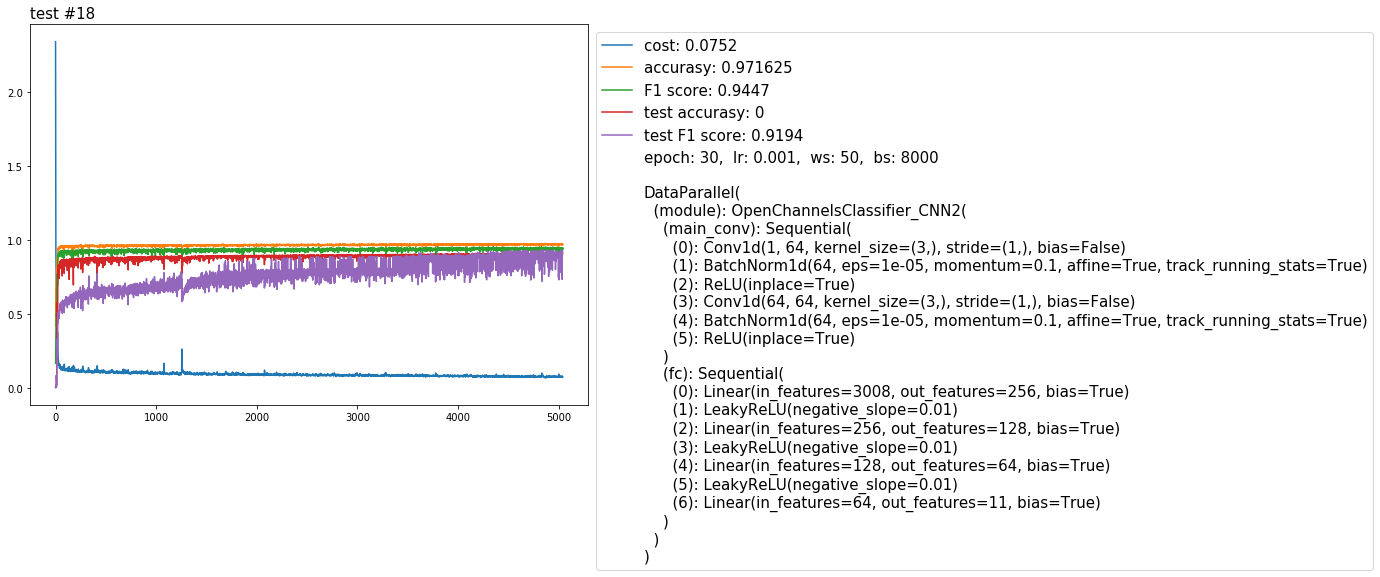

In [56]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='cost: {}'.format(round(train_losses[-1], 4)))
plt.plot(train_accurasy, label='accurasy: {}'.format(accurasy))
plt.plot(train_f1, label='F1 score: {}'.format(round(train_f1[-1], 4)))
plt.plot(test_accurasy, label='test accurasy: {}'.format(t_accurasy))
plt.plot(test_f1, label='test F1 score: {}'.format(round(test_f1[-1], 4)))
plt.plot([], [], ' ', label="epoch: {},  lr: {},  ws: {},  bs: {}\n\n{}".format(num_epochs, lr, ws, btch_sz, model))
plt.title('test #18', fontsize=15, loc='left')
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.show()

In [21]:
df = pd.read_csv("./data/train_thrCK.csv")

for c in range(11):
    df['s'+str(c)] = np.ones(len(df))

In [34]:
df.to_csv("./data/test_thrCK_seqCNN.csv", index=False)

In [38]:
import dataUtils.ionUtils as ionUtils
reload(ionUtils);

num_classes = 11
bNr_train = 6

In [ ]:
df = pd.read_csv("./data/train_thrCK.csv")
for c in range(11):
    df['s'+str(c)] = np.ones(len(df))

# Test the model
softmax=nn.Softmax(dim=1)
with torch.no_grad():
    for i,batch in enumerate(dataloader):
#         inputs = batch['seq'].float().to(device)
    
        inputs = batch['signal'].float().to(device)
        inputs = inputs.view(len(inputs), 1, 49)
        
        indices = batch['index']
        outputs = model(inputs)
        outputs=softmax(outputs)
        outputs = outputs.cpu().detach().numpy()
        df.loc[indices,16:16+num_classes] = outputs
        
#         indices = indices[(outputs.max(axis=1) > 0.9) & (df.iloc[indices,4:15].values.max(axis=1) < 0.4)]
#         print(sum(outputs.max(axis=1) > 0.9))
#         df.loc[indices,4:15] = 1
        
#         indices = batch['index']
#         indices = indices[(outputs.max(axis=1) < 0.8) & (df.iloc[indices,4:15].values.max(axis=1) > 0.8)]
#         print(sum(outputs.max(axis=1) < 0.4) )
#         df.loc[indices,16:16+num_classes] = 1
        
        print('{}/{}'.format(i, len(dataloader)))

In [107]:
df.loc[:,4:15] = 1

In [39]:
for j in np.arange(0.5, 1.01, 0.05):
    print(j,ionUtils.getFullScores(df, thr=j, BR=[bNr_train])[0])

0.5 {'thr': '0.500', 'batch': 6, 'acc': '0.973288', 'f1': '0.966793'}
0.55 {'thr': '0.550', 'batch': 6, 'acc': '0.974182', 'f1': '0.967798'}
0.6000000000000001 {'thr': '0.600', 'batch': 6, 'acc': '0.975030', 'f1': '0.968491'}
0.6500000000000001 {'thr': '0.650', 'batch': 6, 'acc': '0.975538', 'f1': '0.968884'}
0.7000000000000002 {'thr': '0.700', 'batch': 6, 'acc': '0.975844', 'f1': '0.968825'}
0.7500000000000002 {'thr': '0.750', 'batch': 6, 'acc': '0.976054', 'f1': '0.969019'}
0.8000000000000003 {'thr': '0.800', 'batch': 6, 'acc': '0.976184', 'f1': '0.968870'}
0.8500000000000003 {'thr': '0.850', 'batch': 6, 'acc': '0.976234', 'f1': '0.968877'}
0.9000000000000004 {'thr': '0.900', 'batch': 6, 'acc': '0.976274', 'f1': '0.968999'}
0.9500000000000004 {'thr': '0.950', 'batch': 6, 'acc': '0.976274', 'f1': '0.968999'}
1.0000000000000004 {'thr': '1.000', 'batch': 6, 'acc': '0.976274', 'f1': '0.968999'}


In [32]:
indx = df[df.batch == 6].index

In [33]:
df.loc[indx, 16:16+11] = probs_seq

In [ ]:
df[df.batch == 6].iloc[:, 16:16+11]

# Format submmit file

In [51]:
NB = 5

In [73]:
df_test = pd.read_csv('data/test_thrCK.csv')

In [74]:
# indx = df_test[df_test.batch == NB].index
indx = df_test.index
gaus_probs = df_test.iloc[indx, 3:14].values

In [75]:
gaus_probs.shape

(2000000, 11)

In [76]:
probs_seq.shape

(2000000, 11)

In [77]:
df_test.loc[indx, 3:14] = probs_seq*gaus_probs

In [78]:
probs_seq*gaus_probs

array([[9.99999732e-01, 3.96214796e-16, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99999996e-01, 4.89253477e-17, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99999639e-01, 1.08038434e-15, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.99999983e-01, 1.17989895e-19, 1.12297593e-37, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99999997e-01, 9.34892089e-20, 3.00691933e-39, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99999897e-01, 5.33756051e-19, 5.45052451e-36, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [79]:
sum(df_test.iloc[indx, 3:14].values.argmax(axis=1) == (probs_seq*gaus_probs).argmax(axis=1))

2000000

In [80]:
prediction = df_test.iloc[indx, 3:14].values

In [81]:
prediction = prediction.argmax(axis=1)

In [82]:
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [83]:
submmit = pd.read_csv('submmit.csv')
# sum(submmit[submmit.batch == NB].open_channels.values == prediction)/100000
sum(submmit.open_channels.values == prediction)/2000000

0.993609

In [63]:
submmit.open_channels[submmit.batch == NB] = prediction
submmit.to_csv('submmit.csv', index=False)

In [64]:
submmit = pd.read_csv('submmit.csv')
sum(submmit[submmit.batch == NB].open_channels.values == prediction)/100000

1.0

In [266]:
sub_thrCK = pd.read_csv('sub_thrCK_CNN.csv')

In [267]:
prediction

array([10, 10, 10, ...,  7,  9, 10])

In [325]:
sum(sub_thrCK.iloc[submmit_5.index, 1] == prediction)/len(prediction)

0.97355

In [323]:
sum(sub_thrCK.iloc[submmit_5.index, 1] == submmit[submmit.batch == 5].open_channels)/len(prediction)

0.97355

In [273]:
sub_thrCK = pd.read_csv('sub_thrCK.csv')
submmit = pd.read_csv('submmit.csv')

In [269]:
submmit_7 = submmit[submmit.batch == 7].open_channels
submmit_5 = submmit[submmit.batch == 5].open_channels

In [338]:
sub_thrCK.iloc[submmit_5.index, 1] = submmit_5

In [274]:
sum(sub_thrCK.loc[submmit_5.index].open_channels == submmit_5)/100000

0.9676

In [340]:
sub_thrCK.to_csv('sub_thrCK_CNN.csv', float_format='%0.4f', index=False)

In [217]:
sub_thrCK

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
...,...,...
1999995,699.9996,0
1999996,699.9997,0
1999997,699.9998,0
1999998,699.9999,0


In [213]:
def save(model, epoch, loss, path_to_save):
    torch.save({
                'model': model.module.state_dict(),
                'epoch': epoch,
                'loss': loss,
                },
                path_to_save)


In [214]:
save(model=model, epoch=15, loss=np.array([train_losses,train_accurasy]), path_to_save='test_5_7_CNN.pth' )

# Prediction

In [284]:
checkpoint = torch.load('test_5_7_CNN.pth')
model2 = FCC.OpenChannelsClassifier_CNN2(1)
model2.load_state_dict(checkpoint['model'])
model2.to(device)
model2 = torch.nn.DataParallel(model2)

In [65]:
softmax = nn.Softmax(dim=1)

In [66]:
probs_seq = np.empty((0,11))

In [67]:
probs_singl = np.empty((0,11))

In [68]:
probs_seq = np.empty((0,11))

model.eval()
prediction = torch.tensor([]).to(device)
for i, batch in enumerate(dataloader_submmit):
    
    signal = batch['input']
    signal = signal.to(device).float().view(len(batch['input']), 1, ws+1)

    
    with torch.no_grad():
        output = model(signal).view(len(signal), 11)
  
    
    predicted_idx = torch.max(output, 1)[1]
    prediction = torch.cat((prediction, predicted_idx.float()), 0)
    probs_seq = np.concatenate((probs_seq, softmax(output).cpu().detach().numpy()), axis=0)
#     probs_singl = np.concatenate((probs_singl, softmax(output).cpu().detach().numpy()), axis=0)
    
    if i%5 == 0:
        print('[{}/{}]'.format(i, len(dataloader_submmit)))

[0/400]
[5/400]
[10/400]
[15/400]
[20/400]
[25/400]
[30/400]
[35/400]
[40/400]
[45/400]
[50/400]
[55/400]
[60/400]
[65/400]
[70/400]
[75/400]
[80/400]
[85/400]
[90/400]
[95/400]
[100/400]
[105/400]
[110/400]
[115/400]
[120/400]
[125/400]
[130/400]
[135/400]
[140/400]
[145/400]
[150/400]
[155/400]
[160/400]
[165/400]
[170/400]
[175/400]
[180/400]
[185/400]
[190/400]
[195/400]
[200/400]
[205/400]
[210/400]
[215/400]
[220/400]
[225/400]
[230/400]
[235/400]
[240/400]
[245/400]
[250/400]
[255/400]
[260/400]
[265/400]
[270/400]
[275/400]
[280/400]
[285/400]
[290/400]
[295/400]
[300/400]
[305/400]
[310/400]
[315/400]
[320/400]
[325/400]
[330/400]
[335/400]
[340/400]
[345/400]
[350/400]
[355/400]
[360/400]
[365/400]
[370/400]
[375/400]
[380/400]
[385/400]
[390/400]
[395/400]


In [491]:
probs_singl_argmax = np.argmax(probs_singl, axis=1)
probs_seq_argmax   = np.argmax(probs_seq, axis=1)

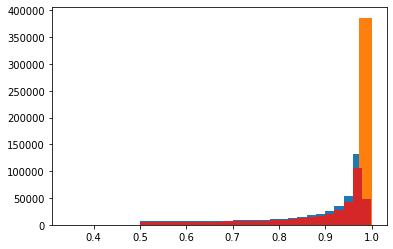

In [477]:
plt.hist(probs_singl.max(axis=1), bins=25)
plt.hist(probs_seq.max(axis=1), bins=25)
plt.hist(probs_singl[probs_singl_argmax == data_test.open_channels.values].max(axis=1), bins=25)
plt.hist(probs_singl[probs_singl_argmax != data_test.open_channels.values].max(axis=1), bins=25)
plt.show()

<IPython.core.display.Javascript object>


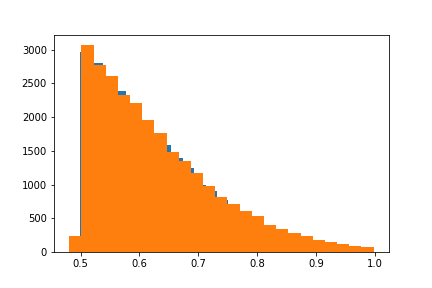

In [147]:
plt.hist(probs_singl[probs_seq_argmax != probs_singl_argmax].max(axis=1), bins=25)
plt.hist(probs_seq[probs_seq_argmax != probs_singl_argmax].max(axis=1), bins=25)
# plt.hist(probs_singl[probs_singl_argmax != data_test.open_channels.values].max(axis=1), bins=25)
# plt.hist(prediction.max(axis=1), bins=25)
plt.show()

In [74]:
prediction.shape

(500000, 11)

In [478]:
prediction = prediction.cpu().detach().numpy()

In [492]:
prediction = np.argmax(probs_seq*probs_singl, axis=1)

In [243]:
prediction = np.argmax(probs_seq, axis=1)

In [244]:
prediction[probs_seq.max(axis=1) < 0.91] = np.argmax(probs_seq[probs_seq.max(axis=1) < 0.91]*probs_singl[probs_seq.max(axis=1) < 0.91], axis=1)

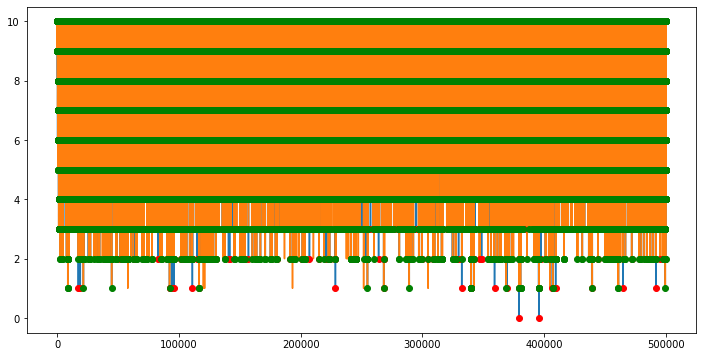

In [482]:
data_test = pd.read_csv('data/dev.csv')
true_indx = data_test.index[prediction == data_test.open_channels.values]
false_indx = data_test.index[prediction != data_test.open_channels.values]
true_data = data_test.open_channels.values[prediction == data_test.open_channels.values]
false_data = data_test.open_channels.values[prediction != data_test.open_channels.values]

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(data_test.open_channels.values)
plt.plot(prediction)
plt.plot(false_indx, false_data, lw=0, marker='o', color='red')
plt.plot(true_indx, true_data, lw=0, marker='o', color='green')
plt.show()

In [480]:
print('accur: signl', sum(prediction == data_test.open_channels.values)/len(prediction))
print('f1: signl',f1_score(data_test.open_channels.values, prediction, average='macro'))

accur: signl 0.823706
f1: signl 0.7114041859388094


In [483]:
print('accur seq: ', sum(prediction == data_test.open_channels.values)/len(prediction))
print('f1 seq: ',f1_score(data_test.open_channels.values, prediction, average='macro'))

accur seq:  0.84726
f1 seq:  0.7351337696028376


In [352]:
print('accur: ', sum(prediction == data_test.open_channels.values)/len(prediction))
print('f1: ',f1_score(data_test.open_channels.values, prediction, average='macro'))

accur:  0.9806505263157895
f1:  0.982546007616218


In [384]:
print('accur seq: ', sum(prediction == data_test.open_channels.values)/len(prediction))
print('f1 seq: ',f1_score(data_test.open_channels.values, prediction, average='macro'))

accur seq:  0.83509
f1 seq:  0.699142267153876


In [387]:
print('accur: ', sum(prediction == data_test.open_channels.values)/len(prediction))
print('f1: ',f1_score(data_test.open_channels.values, prediction, average='macro'))

accur:  0.848864
f1:  0.7179935177758291


In [501]:
prediction.shape

(100000,)

In [506]:
sum(submmit.open_channels[submmit.batch == 5] == prediction)/100000

0.9035

In [507]:
submmit = pd.read_csv('submmit.csv')

In [508]:
submmit = pd.read_csv('submmit.csv')
submmit.open_channels[submmit.batch == 5] = prediction

In [509]:
submmit.to_csv('submmit.csv', index=False)

In [122]:
submmit.groupby('open_channels').count()

,time,signal,batch
open_channels,,,
0,1221046,1221046,1221046
1,215572,215572,215572
2,117129,117129,117129
3,134419,134419,134419
4,81587,81587,81587
5,56372,56372,56372
6,37071,37071,37071
7,52886,52886,52886
8,49684,49684,49684


In [120]:
submmit.groupby('open_channels').count()

,time,signal,batch
open_channels,,,
0,1221046,1221046,1221046
1,215572,215572,215572
2,117129,117129,117129
3,134419,134419,134419
4,81587,81587,81587
5,56372,56372,56372
6,37071,37071,37071
7,52886,52886,52886
8,49684,49684,49684


In [7]:
data
for c in range(10):
    data['s'+str(c)] = np.ones(len(data))

In [10]:
data


,time,signal,open_channels,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,0.0001,-2.7600,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0002,-2.8557,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0003,-2.4074,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0004,-3.1404,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0005,-3.1525,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,499.9996,2.9194,7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4999996,499.9997,2.6980,7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4999997,499.9998,4.5164,8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4999998,499.9999,5.6397,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
